In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from PIL import Image
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [76]:
class Config:
    # Paths
    IMAGE_DIR = 'path/to/durian_images/'  # เปลี่ยนเป็น path ของคุณ
    CSV_FILE = 'durian_leaf.csv'
    SAVE_DIR = 'models/'
    
    # Model - ConvNeXt V2 Options
    MODEL_NAME = 'convnextv2_base.fcmae_ft_in22k_in1k_384'  # ⭐ แนะนำ
    # MODEL_NAME = 'convnextv2_tiny.fcmae_ft_in22k_in1k'
    # MODEL_NAME = 'convnextv2_large.fcmae_ft_in22k_in1k_384'
    # MODEL_NAME = 'convnextv2_huge.fcmae_ft_in22k_in1k_384'  # สำหรับ GPU แรง
    
    NUM_CLASSES = 4
    IMG_SIZE = 384  # ConvNeXt V2 ทำงานได้ดีกับ 384x384
    
    # Training Hyperparameters
    BATCH_SIZE = 16  # ลดลงถ้า GPU ไม่พอ
    EPOCHS = 100
    LEARNING_RATE = 1e-4
    MIN_LR = 1e-6
    WEIGHT_DECAY = 1e-5
    WARMUP_EPOCHS = 5
    
    # Advanced Training
    LABEL_SMOOTHING = 0.1
    MIXUP_ALPHA = 0.2
    CUTMIX_ALPHA = 1.0
    MIXUP_PROB = 0.5
    
    # Cross Validation
    N_FOLDS = 5
    SEED = 42
    
    # System
    NUM_WORKERS = 4
    PIN_MEMORY = True
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Early Stopping
    PATIENCE = 15
    
    # TTA (Test Time Augmentation)
    USE_TTA = True
    TTA_STEPS = 5

config = Config()

# Create save directory
os.makedirs(config.SAVE_DIR, exist_ok=True)

print(f"🚀 Using device: {config.DEVICE}")
print(f"📊 Model: {config.MODEL_NAME}")
print(f"🖼️  Image Size: {config.IMG_SIZE}x{config.IMG_SIZE}")

🚀 Using device: cpu
📊 Model: convnextv2_base.fcmae_ft_in22k_in1k_384
🖼️  Image Size: 384x384


In [77]:
# ==================== Dataset ====================
class DurianLeafDataset(Dataset):
    def __init__(self, df, transform=None, mixup_fn=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.mixup_fn = mixup_fn
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_name = row['id']
        if not img_name.endswith(('.jpg', '.jpeg', '.png')):
            img_name = img_name + '.jpg'  # ปรับตามนามสกุลไฟล์ของคุณ
        
        img_path = os.path.join(config.IMAGE_DIR, img_name)
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        # Get label
        label = int(row['predict'])
        
        # Apply transforms
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

In [78]:
# ==================== Data Augmentation ====================
def get_train_transforms():
    """Training transforms with strong augmentation"""
    return A.Compose([
        # Resize and basic transforms
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        
        # Geometric transforms
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.2,
            rotate_limit=45,
            border_mode=0,
            p=0.7
        ),
        
        # Advanced augmentations
        A.OneOf([
            A.ElasticTransform(alpha=1, sigma=50, p=1),
            A.GridDistortion(p=1),
            A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
        ], p=0.3),
        
        # Color augmentations
        A.OneOf([
            A.RandomBrightnessContrast(
                brightness_limit=0.3,
                contrast_limit=0.3,
                p=1
            ),
            A.HueSaturationValue(
                hue_shift_limit=20,
                sat_shift_limit=30,
                val_shift_limit=20,
                p=1
            ),
            A.RGBShift(
                r_shift_limit=20,
                g_shift_limit=20,
                b_shift_limit=20,
                p=1
            ),
        ], p=0.5),
        
        # Noise and blur
        A.OneOf([
            A.GaussNoise(var_limit=(10.0, 50.0), p=1),
            A.GaussianBlur(blur_limit=(3, 7), p=1),
            A.MotionBlur(blur_limit=7, p=1),
            A.MedianBlur(blur_limit=7, p=1),
        ], p=0.3),
        
        # Weather effects (simulating outdoor conditions)
        A.OneOf([
            A.RandomRain(p=1),
            A.RandomShadow(p=1),
            A.RandomFog(p=1),
        ], p=0.2),
        
        # Cutout
        A.CoarseDropout(
            max_holes=8,
            max_height=32,
            max_width=32,
            fill_value=0,
            p=0.3
        ),
        
        # Normalize (ImageNet stats)
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ])

def get_valid_transforms():
    """Validation transforms - minimal augmentation"""
    return A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ])

def get_tta_transforms():
    """Test-Time Augmentation transforms"""
    return A.Compose([
        A.Resize(config.IMG_SIZE, config.IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ])

In [79]:
# ==================== Mixup & CutMix ====================
class MixupCutmix:
    def __init__(self, mixup_alpha=0.2, cutmix_alpha=1.0, prob=0.5, num_classes=4):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.prob = prob
        self.num_classes = num_classes
    
    def __call__(self, batch):
        if np.random.rand() > self.prob:
            return batch
        
        images, labels = batch
        
        if np.random.rand() < 0.5:
            # Mixup
            return self.mixup(images, labels)
        else:
            # CutMix
            return self.cutmix(images, labels)
    
    def mixup(self, images, labels):
        batch_size = images.size(0)
        lam = np.random.beta(self.mixup_alpha, self.mixup_alpha)
        
        index = torch.randperm(batch_size).to(images.device)
        mixed_images = lam * images + (1 - lam) * images[index]
        
        labels_a = torch.zeros(batch_size, self.num_classes).to(images.device)
        labels_b = torch.zeros(batch_size, self.num_classes).to(images.device)
        labels_a.scatter_(1, labels.unsqueeze(1), 1)
        labels_b.scatter_(1, labels[index].unsqueeze(1), 1)
        
        mixed_labels = lam * labels_a + (1 - lam) * labels_b
        
        return mixed_images, mixed_labels
    
    def cutmix(self, images, labels):
        batch_size = images.size(0)
        lam = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
        
        index = torch.randperm(batch_size).to(images.device)
        
        # Get random box
        _, _, H, W = images.shape
        cut_rat = np.sqrt(1.0 - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)
        
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        # Apply cutmix
        mixed_images = images.clone()
        mixed_images[:, :, bby1:bby2, bbx1:bbx2] = images[index, :, bby1:bby2, bbx1:bbx2]
        
        # Adjust lambda
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
        
        labels_a = torch.zeros(batch_size, self.num_classes).to(images.device)
        labels_b = torch.zeros(batch_size, self.num_classes).to(images.device)
        labels_a.scatter_(1, labels.unsqueeze(1), 1)
        labels_b.scatter_(1, labels[index].unsqueeze(1), 1)
        
        mixed_labels = lam * labels_a + (1 - lam) * labels_b
        
        return mixed_images, mixed_labels

In [80]:
# ==================== Model ====================
class ConvNeXtV2Classifier(nn.Module):
    def __init__(self, model_name=config.MODEL_NAME, num_classes=config.NUM_CLASSES, pretrained=True):
        super().__init__()
        
        # Load ConvNeXt V2 from timm
        self.model = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes,
            drop_path_rate=0.2  # Stochastic depth for regularization
        )
        
        print(f"✅ Loaded model: {model_name}")
        print(f"📊 Number of parameters: {sum(p.numel() for p in self.parameters()):,}")
        
    def forward(self, x):
        return self.model(x)

In [81]:
# ==================== Training Functions ====================
def train_epoch(model, loader, criterion, optimizer, scheduler, device, mixup_fn, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(loader, desc=f'Training Epoch {epoch}')
    
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # Apply Mixup/CutMix
        use_mixup = np.random.rand() < config.MIXUP_PROB
        if use_mixup:
            images, labels_mixed = mixup_fn((images, labels))
            
            optimizer.zero_grad()
            outputs = model(images)
            
            # For mixed labels, use KL divergence or cross entropy with soft labels
            loss = -(labels_mixed * torch.log_softmax(outputs, dim=1)).sum(dim=1).mean()
        else:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        
        if not use_mixup:
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    if scheduler is not None:
        scheduler.step()
    
    train_acc = 100 * correct / total if total > 0 else 0
    return running_loss / len(loader), train_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return running_loss / len(loader), accuracy * 100, f1, all_preds, all_labels

def validate_with_tta(model, loader, device, num_tta=5):
    """Validation with Test-Time Augmentation"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='TTA Validation'):
            batch_preds = []
            
            # Original prediction
            images_device = images.to(device)
            outputs = model(images_device)
            batch_preds.append(torch.softmax(outputs, dim=1))
            
            # TTA augmentations
            for _ in range(num_tta - 1):
                # Horizontal flip
                flipped = torch.flip(images_device, dims=[3])
                outputs = model(flipped)
                batch_preds.append(torch.softmax(outputs, dim=1))
            
            # Average predictions
            avg_pred = torch.stack(batch_preds).mean(dim=0)
            _, predicted = torch.max(avg_pred, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return accuracy * 100, f1, all_preds, all_labels

In [82]:
# ==================== Main Training ====================
def train_model():
    # Set random seeds
    torch.manual_seed(config.SEED)
    np.random.seed(config.SEED)
    
    # Load data
    df = pd.read_csv(config.CSV_FILE)
    
    print(f"\n📊 Dataset Overview:")
    print(f"Total samples: {len(df)}")
    print(f"\nClass Distribution:")
    class_dist = df['predict'].value_counts().sort_index()
    class_names = ['ไม่มีโรค', 'แมลง', 'เชื้อรา', 'เพลี้ย']
    for idx, count in class_dist.items():
        print(f"  Class {idx} ({class_names[idx]}): {count} samples ({count/len(df)*100:.1f}%)")
    
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=config.N_FOLDS, shuffle=True, random_state=config.SEED)
    
    fold_results = []
    all_fold_preds = []
    all_fold_labels = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['predict'])):
        print(f"\n{'='*70}")
        print(f"🔥 Fold {fold + 1}/{config.N_FOLDS}")
        print(f"{'='*70}")
        
        train_df = df.iloc[train_idx]
        val_df = df.iloc[val_idx]
        
        # Datasets
        train_dataset = DurianLeafDataset(train_df, transform=get_train_transforms())
        val_dataset = DurianLeafDataset(val_df, transform=get_valid_transforms())
        
        # DataLoaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=config.BATCH_SIZE,
            shuffle=True,
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=config.BATCH_SIZE,
            shuffle=False,
            num_workers=config.NUM_WORKERS,
            pin_memory=config.PIN_MEMORY
        )
        
        # Model
        model = ConvNeXtV2Classifier().to(config.DEVICE)
        
        # Loss function with class weights
        class_counts = train_df['predict'].value_counts().sort_index()
        class_weights = torch.FloatTensor([
            len(train_df) / (len(class_counts) * count) 
            for count in class_counts
        ]).to(config.DEVICE)
        
        criterion = nn.CrossEntropyLoss(
            weight=class_weights,
            label_smoothing=config.LABEL_SMOOTHING
        )
        
        # Mixup/CutMix
        mixup_fn = MixupCutmix(
            mixup_alpha=config.MIXUP_ALPHA,
            cutmix_alpha=config.CUTMIX_ALPHA,
            prob=config.MIXUP_PROB,
            num_classes=config.NUM_CLASSES
        )
        
        # Optimizer
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        
        # Scheduler with warmup
        scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=config.EPOCHS - config.WARMUP_EPOCHS,
            eta_min=config.MIN_LR
        )
        
        # Training loop
        best_val_acc = 0
        best_f1 = 0
        patience_counter = 0
        history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': []}
        
        for epoch in range(1, config.EPOCHS + 1):
            # Warmup learning rate
            if epoch <= config.WARMUP_EPOCHS:
                lr = config.LEARNING_RATE * epoch / config.WARMUP_EPOCHS
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr
            
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, 
                scheduler if epoch > config.WARMUP_EPOCHS else None,
                config.DEVICE, mixup_fn, epoch
            )
            
            val_loss, val_acc, val_f1, val_preds, val_labels = validate_epoch(
                model, val_loader, criterion, config.DEVICE
            )
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            history['val_f1'].append(val_f1)
            
            print(f"\nEpoch {epoch}/{config.EPOCHS}")
            print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | Val F1: {val_f1:.4f}")
            print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
            
            # Save best model
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_f1 = val_f1
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_acc': val_acc,
                    'val_f1': val_f1
                }, f'{config.SAVE_DIR}/best_model_fold{fold+1}.pth')
                patience_counter = 0
                print(f"✅ Saved best model! (Acc: {val_acc:.2f}%, F1: {val_f1:.4f})")
            else:
                patience_counter += 1
            
            # Early stopping
            if patience_counter >= config.PATIENCE:
                print(f"\n⏹️  Early stopping at epoch {epoch}")
                break
        
        # Load best model
        checkpoint = torch.load(f'{config.SAVE_DIR}/best_model_fold{fold+1}.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Final evaluation with TTA
        if config.USE_TTA:
            print(f"\n🔄 Running Test-Time Augmentation...")
            tta_acc, tta_f1, tta_preds, tta_labels = validate_with_tta(
                model, val_loader, config.DEVICE, config.TTA_STEPS
            )
            print(f"TTA Accuracy: {tta_acc:.2f}% | TTA F1: {tta_f1:.4f}")
            
            fold_results.append({
                'fold': fold + 1,
                'best_val_acc': best_val_acc,
                'best_f1': best_f1,
                'tta_acc': tta_acc,
                'tta_f1': tta_f1
            })
            
            all_fold_preds.extend(tta_preds)
            all_fold_labels.extend(tta_labels)
            
            val_preds = tta_preds
            val_labels = tta_labels
        else:
            fold_results.append({
                'fold': fold + 1,
                'best_val_acc': best_val_acc,
                'best_f1': best_f1
            })
            
            all_fold_preds.extend(val_preds)
            all_fold_labels.extend(val_labels)
        
        # Classification Report
        print(f"\n📊 Classification Report (Fold {fold+1}):")
        print(classification_report(
            val_labels, val_preds,
            target_names=class_names,
            digits=4
        ))
        
        # Confusion Matrix
        cm = confusion_matrix(val_labels, val_preds)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names,
                   yticklabels=class_names)
        plt.title(f'Confusion Matrix - Fold {fold+1}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{config.SAVE_DIR}/confusion_matrix_fold{fold+1}.png', dpi=300)
        plt.close()
        
        # Plot training history
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Loss')
        plt.grid(True)
        
        plt.subplot(1, 3, 2)
        plt.plot(history['train_acc'], label='Train Acc')
        plt.plot(history['val_acc'], label='Val Acc')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.title('Accuracy')
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(history['val_f1'], label='Val F1', color='green')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.title('F1 Score')
        plt.grid(True)
        
        plt.tight_layout()
        plt.savefig(f'{config.SAVE_DIR}/training_history_fold{fold+1}.png', dpi=300)
        plt.close()
    
    # ==================== Final Results ====================
    print(f"\n{'='*70}")
    print(f"🏆 FINAL CROSS-VALIDATION RESULTS")
    print(f"{'='*70}\n")
    
    results_df = pd.DataFrame(fold_results)
    print(results_df.to_string(index=False))
    
    print(f"\n📊 Summary Statistics:")
    if config.USE_TTA:
        print(f"Mean Validation Accuracy: {results_df['best_val_acc'].mean():.2f}% ± {results_df['best_val_acc'].std():.2f}%")
        print(f"Mean Validation F1: {results_df['best_f1'].mean():.4f} ± {results_df['best_f1'].std():.4f}")
        print(f"\nMean TTA Accuracy: {results_df['tta_acc'].mean():.2f}% ± {results_df['tta_acc'].std():.2f}%")
        print(f"Mean TTA F1: {results_df['tta_f1'].mean():.4f} ± {results_df['tta_f1'].std():.4f}")
    else:
        print(f"Mean Validation Accuracy: {results_df['best_val_acc'].mean():.2f}% ± {results_df['best_val_acc'].std():.2f}%")
        print(f"Mean Validation F1: {results_df['best_f1'].mean():.4f} ± {results_df['best_f1'].std():.4f}")
    
    # Overall Classification Report
    print(f"\n📊 Overall Classification Report (All Folds):")
    print(classification_report(
        all_fold_labels, all_fold_preds,
        target_names=class_names,
        digits=4
    ))
    
    # Overall Confusion Matrix
    cm_overall = confusion_matrix(all_fold_labels, all_fold_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Overall Confusion Matrix (All Folds)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{config.SAVE_DIR}/confusion_matrix_overall.png', dpi=300)
    plt.close()
    
    # Save results
    results_df.to_csv(f'{config.SAVE_DIR}/cv_results.csv', index=False)
    print(f"\n✅ Results saved to {config.SAVE_DIR}/cv_results.csv")
    
    return results_df

In [83]:
# ==================== Inference Function ====================
def predict_image(model_path, image_path, device=config.DEVICE):
    """Predict single image with TTA"""
    
    # Load model
    model = ConvNeXtV2Classifier().to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    
    transform = get_valid_transforms()
    
    predictions = []
    
    with torch.no_grad():
        # Original
        augmented = transform(image=image)
        img_tensor = augmented['image'].unsqueeze(0).to(device)
        output = model(img_tensor)
        predictions.append(torch.softmax(output, dim=1))
        
        # TTA
        if config.USE_TTA:
            tta_transform = get_tta_transforms()
            for _ in range(config.TTA_STEPS - 1):
                augmented = tta_transform(image=image)
                img_tensor = augmented['image'].unsqueeze(0).to(device)
                output = model(img_tensor)
                predictions.appenRetryTContinuepython                
                predictions.append(torch.softmax(output, dim=1))
    
    # Average predictions
    avg_pred = torch.stack(predictions).mean(dim=0)
    probabilities = avg_pred.cpu().numpy()[0]
    predicted_class = np.argmax(probabilities)
    
    class_names = ['ไม่มีโรค', 'แมลง', 'เชื้อรา', 'เพลี้ย']
    
    print(f"\n🔍 Prediction Results:")
    print(f"Predicted Class: {predicted_class} ({class_names[predicted_class]})")
    print(f"\nClass Probabilities:")
    for i, (name, prob) in enumerate(zip(class_names, probabilities)):
        print(f"  {i}. {name}: {prob*100:.2f}%")
    
    return predicted_class, probabilities

In [84]:
# ==================== Ensemble Prediction ====================
def ensemble_predict(model_paths, image_path, device=config.DEVICE):
    """Ensemble prediction from multiple folds"""
    
    class_names = ['ไม่มีโรค', 'แมลง', 'เชื้อรา', 'เพลี้ย']
    
    # Load image
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    transform = get_valid_transforms()
    
    all_predictions = []
    
    for model_path in model_paths:
        model = ConvNeXtV2Classifier().to(device)
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        with torch.no_grad():
            # TTA for each model
            fold_predictions = []
            
            for _ in range(config.TTA_STEPS):
                augmented = transform(image=image)
                img_tensor = augmented['image'].unsqueeze(0).to(device)
                output = model(img_tensor)
                fold_predictions.append(torch.softmax(output, dim=1))
            
            # Average TTA predictions for this fold
            avg_fold_pred = torch.stack(fold_predictions).mean(dim=0)
            all_predictions.append(avg_fold_pred)
    
    # Average predictions across all folds
    final_pred = torch.stack(all_predictions).mean(dim=0)
    probabilities = final_pred.cpu().numpy()[0]
    predicted_class = np.argmax(probabilities)
    
    print(f"\n🎯 Ensemble Prediction Results:")
    print(f"Predicted Class: {predicted_class} ({class_names[predicted_class]})")
    print(f"Confidence: {probabilities[predicted_class]*100:.2f}%")
    print(f"\nAll Class Probabilities:")
    for i, (name, prob) in enumerate(zip(class_names, probabilities)):
        bar = '█' * int(prob * 50)
        print(f"  {i}. {name:12s}: {bar} {prob*100:.2f}%")
    
    return predicted_class, probabilities

In [85]:
# ==================== Batch Inference ====================
def predict_batch(model_path, image_dir, output_csv='predictions.csv', device=config.DEVICE):
    """Predict on a batch of images"""
    
    model = ConvNeXtV2Classifier().to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    class_names = ['ไม่มีโรค', 'แมลง', 'เชื้อรา', 'เพลี้ย']
    
    results = []
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    transform = get_valid_transforms()
    
    for img_file in tqdm(image_files, desc='Predicting'):
        img_path = os.path.join(image_dir, img_file)
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        image = np.array(image)
        
        predictions = []
        
        with torch.no_grad():
            # TTA
            for _ in range(config.TTA_STEPS):
                augmented = transform(image=image)
                img_tensor = augmented['image'].unsqueeze(0).to(device)
                output = model(img_tensor)
                predictions.append(torch.softmax(output, dim=1))
        
        # Average predictions
        avg_pred = torch.stack(predictions).mean(dim=0)
        probabilities = avg_pred.cpu().numpy()[0]
        predicted_class = np.argmax(probabilities)
        confidence = probabilities[predicted_class]
        
        results.append({
            'filename': img_file,
            'predicted_class': predicted_class,
            'predicted_label': class_names[predicted_class],
            'confidence': confidence,
            'prob_class_0': probabilities[0],
            'prob_class_1': probabilities[1],
            'prob_class_2': probabilities[2],
            'prob_class_3': probabilities[3]
        })
    
    # Save results
    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    
    print(f"\n✅ Predictions saved to {output_csv}")
    print(f"\n📊 Prediction Summary:")
    print(results_df['predicted_label'].value_counts())
    
    return results_df


In [86]:
# ==================== Visualization Functions ====================
def visualize_predictions(image_path, model_path, save_path=None):
    """Visualize prediction with class probabilities"""
    
    class_names = ['ไม่มีโรค', 'แมลง', 'เชื้อรา', 'เพลี้ย']
    colors = ['green', 'orange', 'red', 'purple']
    
    predicted_class, probabilities = predict_image(model_path, image_path)
    
    # Load image
    image = Image.open(image_path)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Show image
    ax1.imshow(image)
    ax1.axis('off')
    ax1.set_title(f'Predicted: {class_names[predicted_class]}\nConfidence: {probabilities[predicted_class]*100:.1f}%', 
                  fontsize=14, fontweight='bold')
    
    # Show probabilities
    bars = ax2.barh(class_names, probabilities, color=colors)
    ax2.set_xlabel('Probability', fontsize=12)
    ax2.set_xlim([0, 1])
    ax2.set_title('Class Probabilities', fontsize=14, fontweight='bold')
    
    # Add percentage labels
    for i, (bar, prob) in enumerate(zip(bars, probabilities)):
        ax2.text(prob + 0.02, i, f'{prob*100:.1f}%', 
                va='center', fontsize=10, fontweight='bold')
    
    # Highlight predicted class
    bars[predicted_class].set_edgecolor('black')
    bars[predicted_class].set_linewidth(3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✅ Visualization saved to {save_path}")
    
    plt.show()
    
    return fig

def plot_class_distribution(df):
    """Plot class distribution"""
    class_names = ['ไม่มีโรค', 'แมลง', 'เชื้อรา', 'เพลี้ย']
    colors = ['green', 'orange', 'red', 'purple']
    
    class_counts = df['predict'].value_counts().sort_index()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot
    bars = ax1.bar(range(len(class_counts)), class_counts.values, color=colors)
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels([f'{i}\n{name}' for i, name in enumerate(class_names)])
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for bar, count in zip(bars, class_counts.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}\n({count/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Pie chart
    ax2.pie(class_counts.values, labels=class_names, colors=colors,
           autopct='%1.1f%%', startangle=90, textprops={'fontsize': 12, 'fontweight': 'bold'})
    ax2.set_title('Class Distribution', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'{config.SAVE_DIR}/class_distribution.png', dpi=300)
    plt.show()
    
    return fig

In [87]:
# ==================== Model Analysis ====================
def analyze_model_performance(results_csv='models/cv_results.csv'):
    """Analyze and visualize model performance across folds"""
    
    df = pd.read_csv(results_csv)
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Validation Accuracy per Fold
    ax1 = axes[0, 0]
    ax1.plot(df['fold'], df['best_val_acc'], marker='o', linewidth=2, markersize=8)
    ax1.axhline(df['best_val_acc'].mean(), color='red', linestyle='--', 
                label=f'Mean: {df["best_val_acc"].mean():.2f}%')
    ax1.fill_between(df['fold'], 
                     df['best_val_acc'].mean() - df['best_val_acc'].std(),
                     df['best_val_acc'].mean() + df['best_val_acc'].std(),
                     alpha=0.2, color='red')
    ax1.set_xlabel('Fold', fontsize=12)
    ax1.set_ylabel('Validation Accuracy (%)', fontsize=12)
    ax1.set_title('Validation Accuracy per Fold', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: F1 Score per Fold
    ax2 = axes[0, 1]
    ax2.plot(df['fold'], df['best_f1'], marker='s', color='green', linewidth=2, markersize=8)
    ax2.axhline(df['best_f1'].mean(), color='darkgreen', linestyle='--',
                label=f'Mean: {df["best_f1"].mean():.4f}')
    ax2.fill_between(df['fold'],
                     df['best_f1'].mean() - df['best_f1'].std(),
                     df['best_f1'].mean() + df['best_f1'].std(),
                     alpha=0.2, color='green')
    ax2.set_xlabel('Fold', fontsize=12)
    ax2.set_ylabel('F1 Score', fontsize=12)
    ax2.set_title('F1 Score per Fold', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: TTA Comparison (if available)
    if 'tta_acc' in df.columns:
        ax3 = axes[1, 0]
        x = np.arange(len(df))
        width = 0.35
        ax3.bar(x - width/2, df['best_val_acc'], width, label='Validation', alpha=0.8)
        ax3.bar(x + width/2, df['tta_acc'], width, label='TTA', alpha=0.8)
        ax3.set_xlabel('Fold', fontsize=12)
        ax3.set_ylabel('Accuracy (%)', fontsize=12)
        ax3.set_title('Validation vs TTA Accuracy', fontsize=14, fontweight='bold')
        ax3.set_xticks(x)
        ax3.set_xticklabels(df['fold'])
        ax3.legend()
        ax3.grid(axis='y', alpha=0.3)
    else:
        axes[1, 0].axis('off')
    
    # Plot 4: Summary Statistics
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    stats_text = f"""
    📊 Performance Summary
    {'='*40}
    
    Validation Accuracy:
      Mean: {df['best_val_acc'].mean():.2f}%
      Std:  {df['best_val_acc'].std():.2f}%
      Min:  {df['best_val_acc'].min():.2f}%
      Max:  {df['best_val_acc'].max():.2f}%
    
    F1 Score:
      Mean: {df['best_f1'].mean():.4f}
      Std:  {df['best_f1'].std():.4f}
      Min:  {df['best_f1'].min():.4f}
      Max:  {df['best_f1'].max():.4f}
    """
    
    if 'tta_acc' in df.columns:
        stats_text += f"""
    TTA Accuracy:
      Mean: {df['tta_acc'].mean():.2f}%
      Std:  {df['tta_acc'].std():.2f}%
      Improvement: +{df['tta_acc'].mean() - df['best_val_acc'].mean():.2f}%
        """
    
    ax4.text(0.1, 0.5, stats_text, fontsize=11, family='monospace',
            verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig(f'{config.SAVE_DIR}/performance_analysis.png', dpi=300)
    plt.show()
    
    return fig

🌿 Durian Leaf Classification with ConvNeXt V2


ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of labels (4).

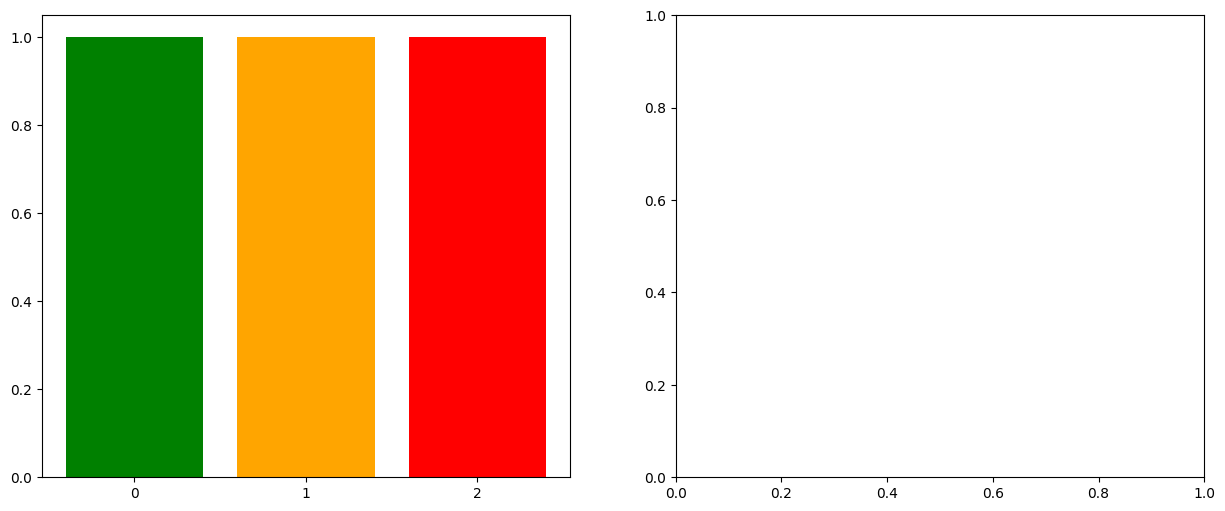

In [88]:
# ==================== Main Execution ====================
if __name__ == '__main__':
    print("🌿 Durian Leaf Classification with ConvNeXt V2")
    print("="*70)
    
    # Check if CSV exists
    if not os.path.exists(config.CSV_FILE):
        print(f"❌ Error: {config.CSV_FILE} not found!")
        print("Please update the CSV_FILE path in Config class.")
    else:
        # Plot class distribution
        df = pd.read_csv(config.CSV_FILE)
        plot_class_distribution(df)
        
        # Train model
        print("\n🚀 Starting training...")
        results = train_model()
        
        # Analyze performance
        print("\n📊 Analyzing model performance...")
        analyze_model_performance()
        
        print("\n✅ Training completed!")
        print(f"📁 Models saved in: {config.SAVE_DIR}")
        
        # Example: Single image prediction
        # predicted_class, probs = predict_image(
        #     'models/best_model_fold1.pth',
        #     'path/to/test_image.jpg'
        # )
        
        # Example: Ensemble prediction
        # model_paths = [f'models/best_model_fold{i}.pth' for i in range(1, 6)]
        # predicted_class, probs = ensemble_predict(
        #     model_paths,
        #     'path/to/test_image.jpg'
        # )
        
        # Example: Batch prediction
        # results = predict_batch(
        #     'models/best_model_fold1.pth',
        #     'path/to/test_images/',
        #     'predictions.csv'
        # )